In [3]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1

In [ ]:
MAX_LENGTH = 10

In [ ]:
# Encoder
class EncoderRNN(nn.Module):
    """
    인코더 RNN 클래스 (GRU 기반)

    입력 문장을 임베딩 후, GRU를 이용해 시퀀스 전체를 인코딩하고,
    디코더가 사용할 context 정보를 반환한다.

    Args:
        input_size (int): 입력 어휘 사전의 크기 (vocab size)
        hidden_size (int): GRU hidden state의 차원
        dropout_p (float, optional): 드롭아웃 비율 (기본값 0.1)

    Inputs:
        input (Tensor): [batch_size, seq_len] 형태의 입력 시퀀스 (단어 인덱스)

    Returns:
        output (Tensor): [batch_size, seq_len, hidden_size], 각 time step의 hidden state
        hidden (Tensor): [1, batch_size, hidden_size], 마지막 hidden state (디코더 초기값)
    """
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size

        # 단어 인덱스를 임베딩 벡터로 변환 (임베딩 차원 = hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # GRU 셀 (batch_first=True: 입력이 [batch, seq, feature] 형태)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
        # Dropout: 학습 중 일부 뉴런 무작위 비활성화로 과적합 방지
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        """
        입력 시퀀스를 인코딩하는 forward 함수

        Args:
            input (Tensor): [batch_size, seq_len] 형태의 단어 인덱스 텐서

        Returns:
            output (Tensor): GRU의 전체 출력, [batch_size, seq_len, hidden_size] (각 time step의 hidden state)
            hidden (Tensor): 마지막 hidden state, [1, batch_size, hidden_size] (마지막 time step의 hidden state)
        """
        embedded = self.dropout(self.embedding(input))    # [batch_size, seq_len] → [batch_size, seq_len, hidden_size]
        output, hidden = self.gru(embedded)    # output, hidden = [batch_size, seq_len, hidden_size], [1, batch_size, hidden_size]

In [ ]:
# BahdanauAttention 클래스
# 목적 : 디코더의 현재 hidden state (query)와 인코더 출력들 (keys) 사이의 유사도를 측정하여, 어텐션 점수를 계산
class BahdanauAttention(nn.Module):
    """
    Args:
        hidden_size (int): 쿼리 및 키의 hidden state 차원
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)    # query (디코더 hidden) 변환
        self.Ua = nn.Linear(hidden_size, hidden_size)    # key (인코더 출력) 변환
        self.Va = nn.Linear(hidden_size, 1)    # 유사도 점수 계산용 선형 변환


    """
    query (Tensor): 디코더 hidden state  
                    shape = [batch_size, 1, hidden_size]
    keys (Tensor): 인코더의 전체 출력 시퀀스  
                    shape = [batch_size, seq_len, hidden_size]
    context (Tensor): 가중합된 인코더 출력 (컨텍스트 벡터)  
                        shape = [batch_size, 1, hidden_size]
    weights (Tensor): 어텐션 가중치  
                        shape = [batch_size, 1, seq_len]
    """
    def forward(self, query, keys):
        # Wa(query): [batch, 1, hidden], Ua(keys): [batch, seq_len, hidden]
        # broadcast 되어 결과 shape: [batch, seq_len, hidden]
        # scores: [batch, seq_len, 1]
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        # scores: [batch, seq_len, 1] → [batch, 1, seq_len]
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)    # [batch, 1, seq_len]
        context = torch.bmm(weights, keys)    # [batch, 1, hidden]

        return context, weights

### attention score 계산 수식
$$e_{ij} = v_a^{T} \cdot tanh(W_a \cdot s_{i-1} + U_a \cdot h_j)$$
##### 왜 **tanh**을 사용할까?
- 만약 이 수식에서 tanh을 제거한다면, 두 벡터 간의 선형관계를 측정하는 단순모델이 되지만 tanh을 추가하면, 쿼리와 키 사이의 복잡한 상호작용(ex. 문맥적 중요성)을 반영할 수 있다. 이를 통해 attention 가중치가 더 세밀하게 조정되어 모델의 성능이 향상된다.

#### **(MEMO)**
- Additive 방식은 내적(dot-product) 방식보다 벡터 간 관계를 비선형적으로 표현할 수 있어 표현력이 풍부하다.
- 각 입력 위치에 얼마나 집중할지를 학습 가능한 방식으로 계산한다.

In [ ]:
# Bahdanau 어텐션을 활용한 GRU 기반 디코더 클래스
# 인코더의 출력과 디코더의 현재 상태를 이용해 어텐션을 적용하고, 이를 통해 매 시점마다 단어를 하나씩 생성한다.
class AttnDecoderRNN(nn.Module):
    """
    Args:
        hidden_size (int): hidden state 차원
        output_size (int): 출력 어휘 수 (target vocabulary size)
        dropout_p (float): 드롭아웃 확률
    """
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Bahdanau 어텐션 모듈
        self.attention = BahdanauAttention(hidden_size)
        
        # context vector (hidden_size) + embedding (hidden_size) → 2 * hidden_size
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        
        # GRU 출력 → 단어 분포 예측
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        # 디코더의 첫 입력 = <SOS> 토큰
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []    # 예측된 단어 분포 저장
        attentions = []    # 어텐션 가중치 저장

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)    # decoder_output: [batch, 1, output_size]
            attentions.append(attn_weights)    # attn_weights: [batch, 1, seq_len]

            if target_tensor is not None:
                # Teacher forcing 포함: 목표(정답 토큰)를 다음 입력으로 전달
                decoder_input = target_tensor[:, i].unsqueeze(1)    # [batch, 1]
            else:
                # Teacher forcing 미포함: **예측 결과**를 다음 입력으로 사용
                _, topi = decoder_output.topk(1)     # topi: [batch, 1, 1]
                decoder_input = topi.squeeze(-1).detach()  # 입력으로 사용할 부분을 히스토리에서 분리    # [batch, 1]

        decoder_outputs = torch.cat(decoder_outputs, dim=1)    # [batch, MAX_LENGTH, output_size]
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)    # [batch, MAX_LENGTH, seq_len]

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))    # [batch, 1, hidden_size]

        query = hidden.permute(1, 0, 2)    # [batch, 1, hidden_size] (쿼리로 사용하기 위해 차원 전치)
        context, attn_weights = self.attention(query, encoder_outputs)    # context: [batch, 1, hidden_size], attn_weights: [batch, 1, seq_len]
        input_gru = torch.cat((embedded, context), dim=2)    # [batch, 1, 2 * hidden_size]

        output, hidden = self.gru(input_gru, hidden)    # [batch, 1, hidden_size]
        output = self.out(output)    # [batch, 1, output_size]

        return output, hidden, attn_weights

#### **(MEMO)**
- GRU 입력은 임베딩과 context 벡터를 결합하여 풍부한 정보를 반영한다.(.cat() 함수 이용)
- attention은 decoder가 매 시점마다 encoder의 전체 정보를 동적으로 참고하게 한다.
- softmax된 attention weights는 시각화하여 모델 해석에 활용 가능할 것으로 보인다.

![이름 없는 노트북-8.jpg](<attachment:이름 없는 노트북-8.jpg>)
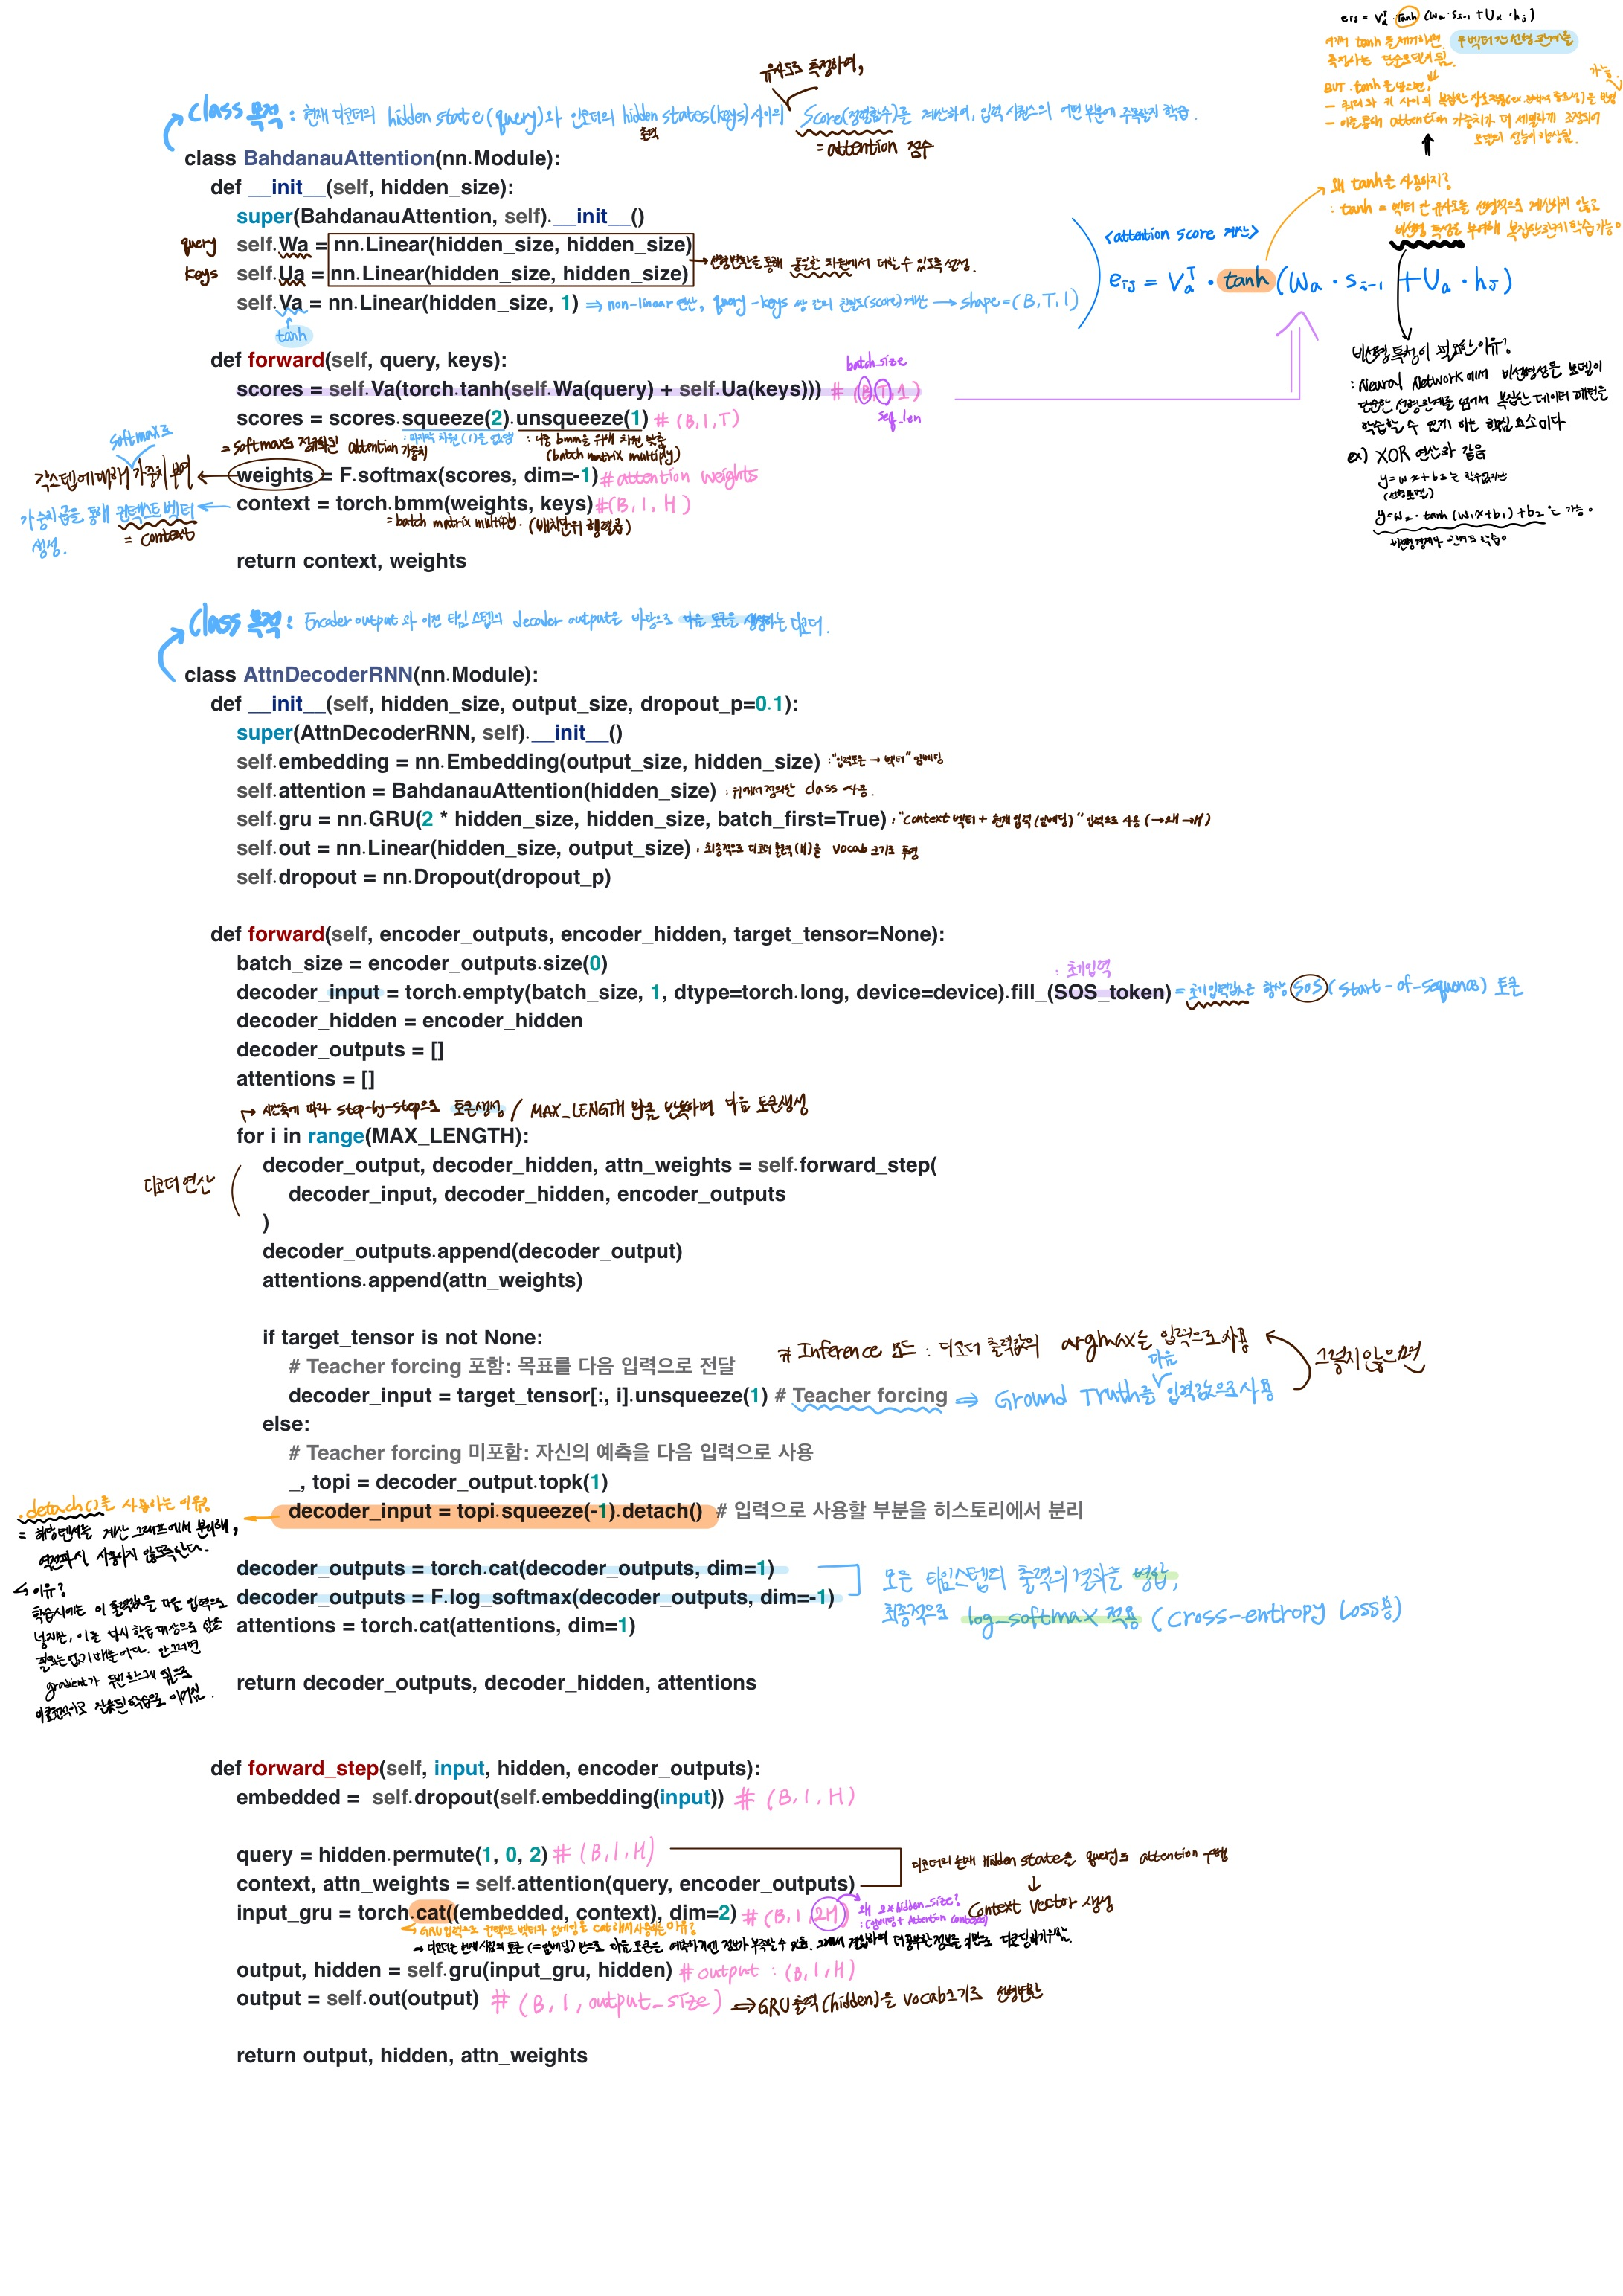